## 📑 `Consensus voting among multiple detection models for vehicle bounding boxes`

van       : 100%|██████████| 485/485 [00:59<00:00,  8.18it/s]


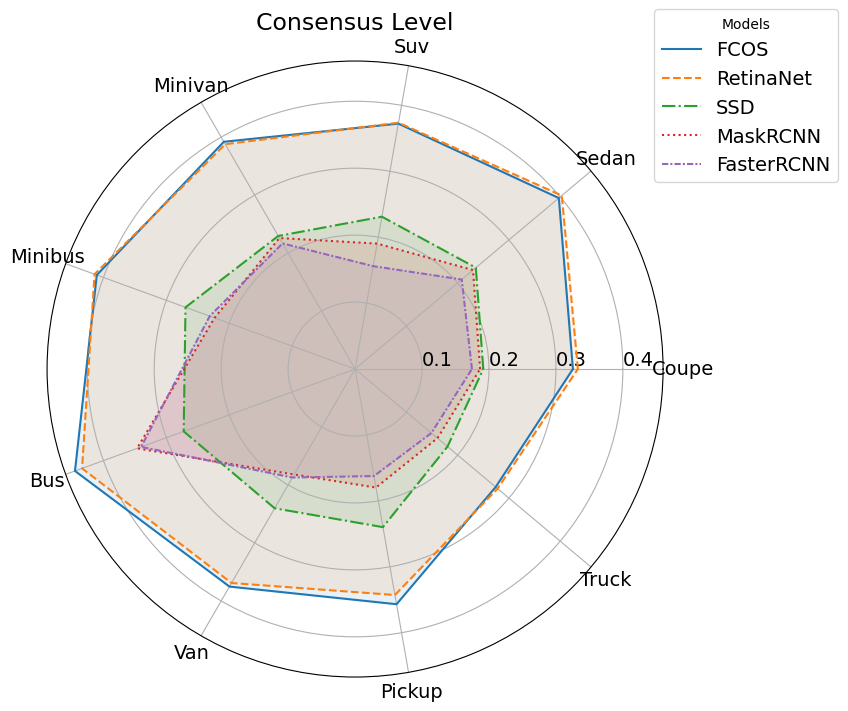

In [1]:
import cv2
import torch
import torchvision.models.detection as detection
from torchvision import transforms
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import random
from src import utils

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load models
models = {
    'RetinaNet': detection.retinanet_resnet50_fpn(weights=detection.RetinaNet_ResNet50_FPN_Weights.DEFAULT),
    'FasterRCNN': detection.fasterrcnn_resnet50_fpn(weights=detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT),
    'MaskRCNN': detection.maskrcnn_resnet50_fpn(weights=detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT),
    'SSD': detection.ssd300_vgg16(weights=detection.SSD300_VGG16_Weights.DEFAULT),
    'FCOS': detection.fcos_resnet50_fpn(weights=detection.FCOS_ResNet50_FPN_Weights.DEFAULT)
}

# Move models to the appropriate device and set to evaluation mode
for model in models.values():
    model.to(device).eval()

def detect_vehicles(image_path, model, device, model_name):
    image = Image.open(image_path)
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        preds = model(image_tensor)

    vehicle_classes = [3, 6, 8]  # COCO classes for vehicles
    pred = preds[0]
    labels = pred['labels'].cpu().numpy()
    boxes = pred['boxes'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()

    max_area = 0
    largest_box = None
    for label, box, score in zip(labels, boxes, scores):
        if label in vehicle_classes and score >= 0.33:
            x1, y1, x2, y2 = box
            area = (x2 - x1) * (y2 - y1)
            if area > max_area:
                max_area = area
                largest_box = (box, model_name)

    return largest_box if largest_box else (None, model_name)

def gather_detections(image_path, models, device):
    model_boxes = {}  # Using a dictionary to map model names to their boxes
    for model_name, model in models.items():
        box = detect_vehicles(image_path, model, device, model_name)
        if box[0] is not None:
            model_boxes[model_name] = box  # Store the box with the model name as key
    return model_boxes

def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    return intersection_area / union_area if union_area != 0 else 0

def consensus_voting(model_boxes, tau=0.95):
    votes = {model: 0 for model in model_boxes}  # Initialize votes for each model
    boxes_items = list(model_boxes.items()) # Convert model_boxes to list of items for easier pairwise comparison
    for i in range(len(boxes_items)):
        model_i, box_i = boxes_items[i]
        for j in range(len(boxes_items)):
            if i != j:
                model_j, box_j = boxes_items[j]
                if iou(box_i[0], box_j[0]) >= tau:
                    votes[model_i] += 1
    return votes

def consensus_level(num_image_per_class=None):
    num_image_for_normalization = num_image_per_class
    folder_path = './datasets/real_raw'
    subfolder_votes = {}
    for subfolder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder_name)
        if os.path.isdir(subfolder_path):
            subfolder_vote_count = {}
            image_files = os.listdir(subfolder_path)  # Get the list of files
            random.shuffle(image_files)  # Shuffle the list of files
            i = 1
            if not num_image_per_class:
                num_image_for_normalization = len(image_files)
            for image_name in tqdm(image_files, desc=f"{subfolder_name}".ljust(10), leave=True):  # Iterate over the shuffled list
                if num_image_per_class and i>num_image_per_class:
                    break
                image_path = os.path.join(subfolder_path, image_name)
                if image_path.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                    all_boxes = gather_detections(image_path, models, device)
                    votes = consensus_voting(all_boxes)
                    for model_name, vote in votes.items():
                        if model_name not in subfolder_vote_count:
                            subfolder_vote_count[model_name] = 0
                        subfolder_vote_count[model_name] += vote/num_image_for_normalization/4.0
                i+=1
            subfolder_votes[subfolder_name.upper()] = subfolder_vote_count
    return subfolder_votes

utils.plot_radar_chart(consensus_level())